## Actividad 06 - Validación cruzada en un conjunto de datos bancarios
#### Oscar Alejandro Duarte Bonilla

#### DATASET
Los datos están relacionados con campañas de marketing directo (llamadas telefónicas) de una institución bancaria portuguesa. El objetivo de la clasificación es predecir si el cliente suscribirá un depósito a plazo (variable y).
Nota: El dataset no contiene valores faltantes
##### https://archive.ics.uci.edu/dataset/222/bank+marketing
#### Variable Objetivo
###### y - ¿El cliente ha suscrito un depósito a plazo?, binary: "yes","no"
#### Variables Predictoras
###### age - Edad
###### job - Tipo de trabajo (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")
###### marital - Estado civil (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
###### education - (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
###### default - ¿Tiene crédito en mora? (binary: "yes","no")
###### balance - Saldo medio anual en Euros (numeric) 
###### housing - ¿Tiene préstamo para vivienda? (binary: "yes","no")
###### loan - ¿Tiene un préstamo personal? (binary: "yes","no")
###### contact - Tipo de comunicación de contacto (categórico: "unknown","telephone","cellular") 
###### day_of_week - Último día de contacto de la semana(numeric)
###### month - Último mes del año en contacto (categórico: "jan", "feb", "mar", ..., "nov", "dec")
###### duration - Duración del último contacto, en segundos (numérico).
###### *** Nota importante: este atributo afecta en gran medida al objetivo de salida (por ejemplo, si duration=0 then y='no'). Sin embargo, no se conoce la duración antes de que se realice una llamada. Además, después del final de la llamada se conoce obviamente y. Por lo tanto, esta entrada solo debe incluirse con fines de referencia y debe descartarse si la intención es tener un modelo predictivo realista. ***
###### campaign - Número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)
###### pdays - Número de días que transcurrieron desde la última vez que el cliente fue contactado de una campaña anterior (numérico; -1 significa que el cliente no fue contactado anteriormente)
###### previous - Número de contactos realizados antes de esta campaña y para este cliente
###### poutcome - Resultado de la campaña de marketing anterior (categorical: 'failure','nonexistent','success')

#### Total de columnas
##### 15 de entrada(features)
##### 1 objetivo

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

In [147]:
# Cargar dataset
df = pd.read_csv("bank.csv", sep=';')
y = df["y"].map({'yes': 1, 'no': 0})  # copiar la columna Y del df y binarizar su valor

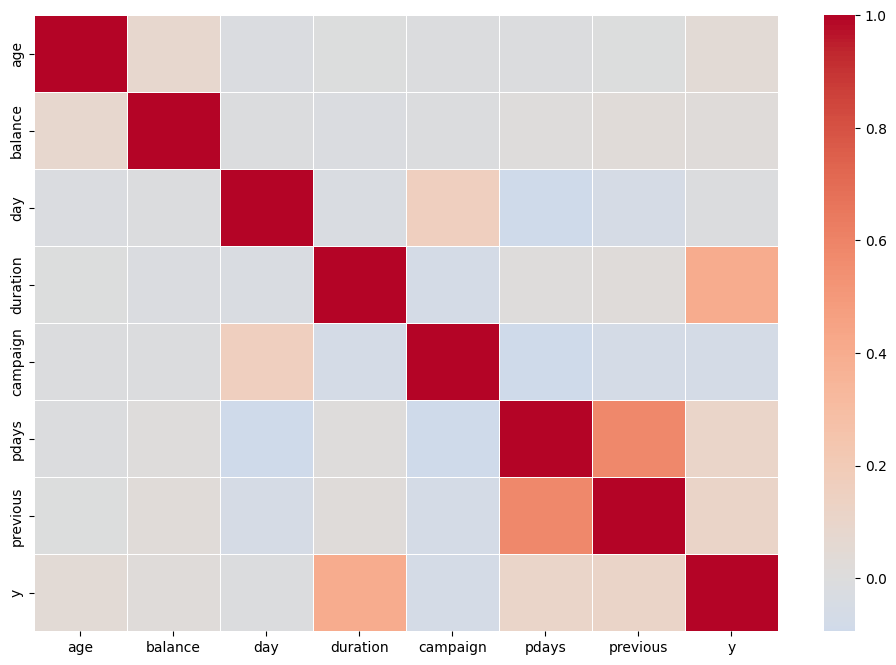

In [148]:
# Justificacion de la eliminacion de la columna "duration"
# Segun la nota del dataset esta variable influye grandemente en la varible taget, si duration=0 entonces y=0. 
# La recomendacion es eliminarla si se busca crear un modelo predictor realista
# A pesar que no es parte de la tarea se realizó una verificación con el mapa de calor encontrando una correlacion moderada de "duration" con la variable target

df_num = df.select_dtypes(include='number')
result = pd.concat([df_num, y], axis=1)
plt.figure(figsize=(12,8))
sns.heatmap(result.corr(), annot=False, cmap='coolwarm', center=0, linewidths=0.5)
plt.show()

In [149]:
df['y'].value_counts()

y
no     4000
yes     521
Name: count, dtype: int64

In [150]:
#Es necesario balancer clases
df_majority = df[df.y == "no"]
df_minority = df[df.y == "yes"]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced['y'].value_counts()

y
no     4000
yes    4000
Name: count, dtype: int64

In [151]:
# Variables
X = df_balanced.drop(["y", "duration"], axis=1) #Copiar el df a excepcion de la columna y y duration
y = df_balanced["y"].map({'yes': 1, 'no': 0})  # copiar la columna Y del df y binarizar su valor

In [152]:
# Identificar variables numéricas y categóricas
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

In [153]:
# Preprocesamiento por tipo de columna
# Escalar variables numéricas(Varianza 1, media 0) y Convertir las variables categoricas a variables binarias evitando colinealidad
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features),
    ]
)

In [154]:
# Crear pipeline con modelo
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

In [155]:
# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [156]:
# Definir K-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [157]:
# Definir métricas
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

In [158]:
# Cross-validation
results = cross_validate(pipeline, X_train, y_train, cv=kf, scoring=scoring)
#cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring="accuracy")

In [159]:
# Promedio y desviación
print("Metrica: Media ± DesvStd")
for metric in scoring.keys():
    print(f"{metric}: {results['test_' + metric].mean():.4f} ± {results['test_' + metric].std():.4f}")

Metrica: Media ± DesvStd
accuracy: 0.9727 ± 0.0042
precision: 0.9544 ± 0.0092
recall: 0.9925 ± 0.0042
f1: 0.9731 ± 0.0050


In [160]:
# Entrenar el modelo en todo el training set y evaluar en test
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

In [161]:
# Matriz de Confusión y Accuracy
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

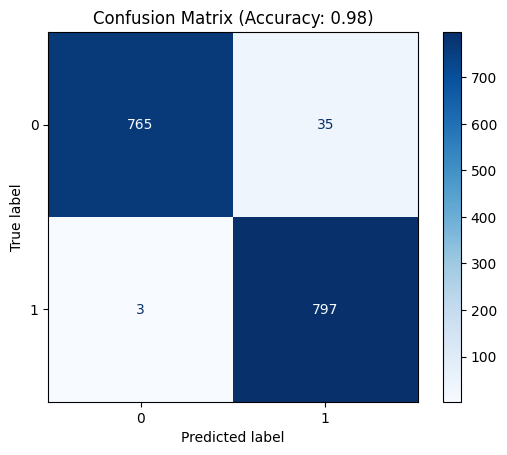

In [163]:
# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Accuracy: {acc:.2f})")
plt.show()

TP: 797, FN:3(omisiones) , TN:765, FP: 35(Falsos alarmas)